# Using the ml4qc package for a specific example analysis ("CATI2")

This workbook demonstrates an example analysis for a particular CATI survey example, using data collected with [SurveyCTO](https://www.surveycto.com). To preserve project confidentiality, the project is simply referred to as "CATI2".

This is a basic proof-of-concept project designed to explore the potential for ML-based tools to identify outliers and submissions that are likely to be rejected by a human reviewer. The project collected essentially all possible metadata for a CATI survey, as well as the results of audio audit reviews. All submissions were reviewed.

In this case, the sample size is so small (only 25 rejected submissions, out of 531) that it's difficult to (a) tune, (b) train, and (c) test models. Five-fold cross-validation processes used for tuning and evaluation, in particular, end up with very few observations in the rejected class. That said, the results strongly suggest that the metadata is predictive, with 30-50% precision (against a base rate of 4.7%) even with the very small training set. Also, rejected submissions are 8x more likely to be flagged as outliers, suggesting that outlier status is itself somewhat predictive of rejection. Finally, tuning results are broadly similar to the CATI1 example, suggesting that we can reasonably begin by tuning one CATI survey with the parameters from another.

In [14]:
# for convenience, auto-reload modules when they've changed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data from SurveyCTO export

Here, we use the [surveydata](https://surveydata.readthedocs.io/) package to load the data and prep it for analysis. This includes loading and then processing all [text audits](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zd.field-types-text-audit.html), converting from the original long format (one `.csv` file per submission) to a wide format that we merge into the main dataset. In addition to the text audit files, the main .csv file includes the following columns:

* **SubmissionDate** - Date submission received by SurveyCTO server
* **starttime** - Device date and time form was first opened to fill out
* **endtime** - Device date and time form was completed
* **duration** - Total number of seconds spent editing form
* **instance_time** - Timestamp in an unusual format; will be dropped
* **TA** - Relative path to text audit `.csv` file
* **pct_conversation** - Percent of form-editing time when conversation was detected ([sensor metadata](https://docs.surveycto.com/02-designing-forms/01-core-concepts/03zf.field-types-sensor-statistic.html))
* **review_status** - Current review status (APPROVED, REJECTED, or NONE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **Surveyor_ID** - ID of enumerator who conducted the interview
* **audio_review_status** - Result of audio review
* **review_quality** - Reviewed submission quality (GOOD, OKAY, POOR, or FAKE; part of the [review and correction workflow](https://docs.surveycto.com/04-monitoring-and-management/01-the-basics/04.reviewing-and-correcting.html))
* **KEY** - Unique submission ID

In [15]:
%%time

import os
import pandas as pd
import pytz
from surveydata import SurveyCTOPlatform
from surveydata import SurveyCTOExportStorage

# manually set our data and collection timezones
# (needed in this case because the storage and text audit formats used don't themselves include timezone info)
data_tz = pytz.timezone("Asia/Kabul").zone
collection_tz = pytz.timezone("Asia/Kabul").zone

# initialize local storage with .csv file and attachments_available=True since media subdirectory is present
storage = SurveyCTOExportStorage(export_file=os.path.expanduser("~/ml4qc-data/collab1/cati2/cati2.csv"), attachments_available=True)

# load all submissions into DataFrame and describe contents
submissions_df = SurveyCTOPlatform.get_submissions_df(storage)
print("Submission DataFrame field counts:")
print(submissions_df.count(0))
print()

# summarize submission review status and quality
print("Submission DataFrame review status and quality:")
print(submissions_df.review_status.value_counts())
print(submissions_df.review_quality.value_counts())
print(submissions_df.audio_review_status.value_counts())
print()

# load all text audits into DataFrame and describe contents
textaudit_df = SurveyCTOPlatform.get_text_audit_df(storage, location_strings=submissions_df.text_audit_full)
if textaudit_df is not None:
    print("Text audit DataFrame field counts:")
    print(textaudit_df.count(0))
    print()

    # summarize text audits in wide format
    ta_summary = SurveyCTOPlatform.process_text_audits(textaudit_df, submissions_df["starttime"], submissions_df["endtime"], data_tz, collection_tz)

    # merge text wide-format audit summaries with submission data
    all_data = pd.concat([submissions_df, ta_summary], axis='columns', join='outer', verify_integrity=True)

    # print summary of combined DataFrame
    print("Combined DataFrame field counts:")
    print(all_data.count(0))
else:
    print("No text audits found.")

    all_data = submissions_df

Submission DataFrame field counts:
SubmissionDate         531
starttime              531
endtime                531
deviceid               531
subscriberid           531
simid                  531
duration               531
caseid                 531
text_audit_full        531
pct_conversation       531
review_status          531
Surveyor_ID            531
audio_review_status    531
review_quality         531
dtype: int64

Submission DataFrame review status and quality:
APPROVED    506
REJECTED     25
Name: review_status, dtype: Int64
GOOD    506
POOR     25
Name: review_quality, dtype: Int64
QA APPROVED             506
QA REJECTED              13
INCOMPLETE INTERVIEW     12
Name: audio_review_status, dtype: Int64

Text audit DataFrame field counts:
device_time      37692
form_time_ms     37692
field            35906
event            37692
duration_ms      35906
Choice values    25559
Choice labels    25559
dtype: int64

Combined DataFrame field counts:
SubmissionDate                  

## Prepping data for analysis

Here, we organize our features and the classes that we'll be working to predict, and we preprocess the data to prepare for binary classification prediction using one of three target definitions:

1. Rejected submissions
2. Submissions classified as poor quality
3. Submissions that are not APPROVED as GOOD quality (i.e., rejected or another quality)

Here, we use PCA to reduce our feature dimensions, targeting 95% variance retention. This allows ML model training and validation to be much faster.

Since this is a static *ex post* dataset with all submissions already reviewed, we use 75% of the data for training and 25% for testing (our prediction set).

In [16]:
%%time

from ml4qc import SurveyMLClassifier

# optional dimensionality reduction with PCA (None for no PCA, float (0, 1) for % variance to retain
pca = 0.95

# random state for reproducible results (or None)
random_state = 410

# make a copy of the data for analysis, so that we can transform it at will, dropping columns we don't need and rows with missing values
analysis_df = all_data.drop(["SubmissionDate", "starttime", "endtime", "deviceid", "text_audit_full", "subscriberid", "simid", "caseid", "Surveyor_ID"], axis=1).copy(deep=True)
starting_n = len(analysis_df.index)
analysis_df = analysis_df[~analysis_df.isnull().any(axis=1)]
ending_n = len(analysis_df.index)
print(f"Dropped {starting_n-ending_n}/{starting_n} observations with missing data, for a loss of {((starting_n-ending_n)/starting_n)*100:.2f}%")
print()

# organize DataFrames with features and classes for prediction
classes_df = analysis_df.loc[:, ["review_status", "review_quality", "audio_review_status"]]
features_df = analysis_df.drop(["review_status", "review_quality", "audio_review_status"], axis=1)

# set our target for prediction
target_description = "REJECTED"
classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_status"] == "REJECTED" else 0), axis=1)
# target_description = "POOR"
# classes_df["target"] = classes_df.apply(lambda row: (1 if row["review_quality"] == "POOR" else 0), axis=1)
# target_description = "Not APPROVED+GOOD"
# classes_df["target"] = classes_df.apply(lambda row: (0 if row["review_status"] == "APPROVED" and row["review_quality"] == "GOOD" else 1), axis=1)
target_df = pd.DataFrame(classes_df["target"])
print(f"Target description: {target_description}")
print(target_df.target.value_counts())
print()
print(f"Target base rate: {(len(target_df[target_df.target == 1])/len(target_df))*100:.2f}%")
print()

# create SurveyML object with 40% test vs. train size
surveyml = SurveyMLClassifier(features_df, target_df, test_size=0.40, cv_when_training=True, random_state=random_state, verbose=True, n_jobs=-3, calibration_method='isotonic', threshold="optimal_f", threshold_value=1)

# preprocess data
surveyml.preprocess_for_prediction(pca=pca)

Dropped 0/531 observations with missing data, for a loss of 0.00%

Target description: REJECTED
0    506
1     25
Name: target, dtype: int64

Target base rate: 4.71%

numeric features: 1176
numeric_binary features: 153
numeric_unit_interval features: 853
numeric_other features: 170
datetime features: 0
other features: 2
  Starting training set shape: (318, 1178)
Starting prediction set shape: (213, 1178)
     Final training set shape: (318, 144)
   Final prediction set shape: (213, 144)
CPU times: user 1.49 s, sys: 195 ms, total: 1.69 s
Wall time: 648 ms


## Performing analysis

In the cells that follow, we perform a series of analyses using the `scikit-learn` and `Tensorflow Keras` libraries, making use of the utilities available in the `SurveyMLClassifier` class. These models have not been extensively tuned, and they currently require re-tuning whenever the target or dimensionality-reduction settings change above.

### Identifying outliers

First, however, we use the `identify_outliers()` method available in the base `SurveyML` class, to identify outliers and save them to disk.

In [17]:
%%time

model_description = "Isolation forest outlier detection"
print(f"       Model: {model_description}")
print()

# identify outliers
x_outlier_df = surveyml.identify_outliers()

# save results to .csv
x_outlier_df.to_csv(os.path.expanduser("~/ml4qc-data/collab1/cati2/outlier_predictions.csv"))

# combine outlier prediction with target classification and show crosstab
x_outlier_df = x_outlier_df.join(target_df)
pd.crosstab(x_outlier_df.is_outlier, x_outlier_df.target).apply(lambda c: c/c.sum(), axis=0)

       Model: Isolation forest outlier detection

Outliers: 8 (1.5065913370998116%)
CPU times: user 315 ms, sys: 33.6 ms, total: 348 ms
Wall time: 356 ms


target,0,1
is_outlier,,
0,0.988142,0.92
1,0.011858,0.08


### Binary classification prediction with logistic regression

Here, we use logistic regression to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Logistic regression
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.029876414094914535
Parameters: {'C': 0.07722169312991713, 'class_weight': None, 'penalty': 'l2'}

Running prediction model...

      Training set: (318, 144) (13 positive)
    Prediction set: (213, 144)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.4729484457241403

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  93.43%
    Prediction precision:  0.00%
          Prediction F-1:  0.0
      Test ROC_AUC Score:  0.5


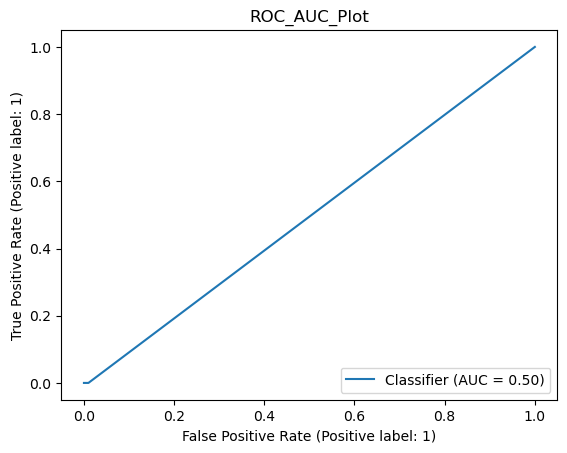

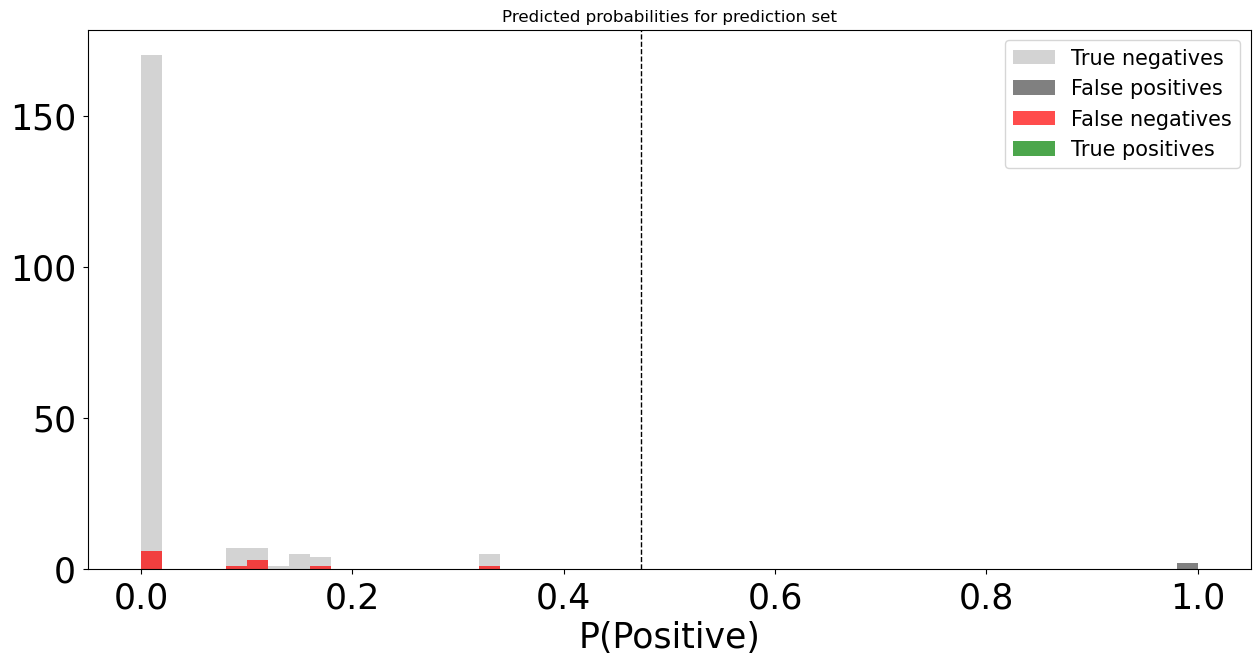

Test P(1) =  5.63%
Test P(1 | predicted 1) =  0.00%
Test P(1 | predicted 0) =  5.69%

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       201
           1       0.00      0.00      0.00        12

    accuracy                           0.93       213
   macro avg       0.47      0.50      0.48       213
weighted avg       0.89      0.93      0.91       213



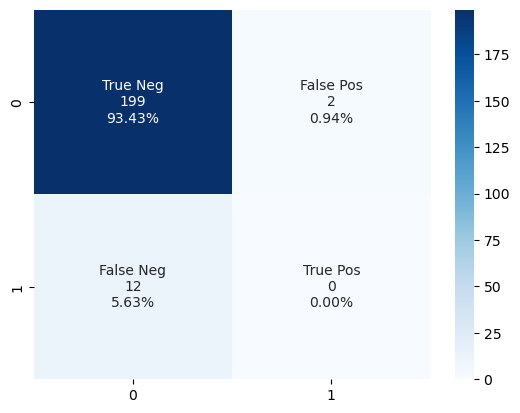

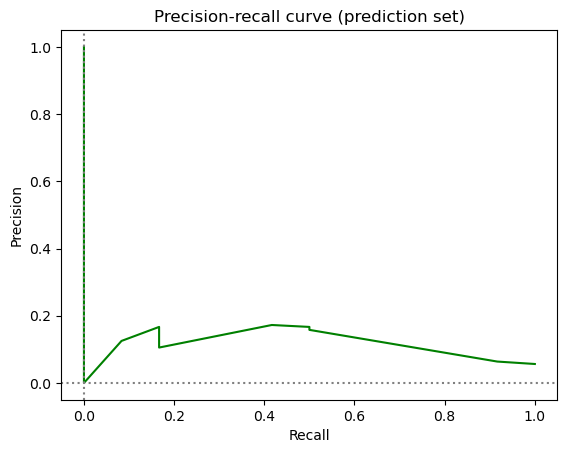

Cross validation results: 

fit_time: 0.03520016670227051 (SD: 0.0038158941985908692)
score_time: 0.0022396246592203775 (SD: 0.00038423003125162135)
test_accuracy: 0.9602678571428572 (SD: 0.02117639250687599)
test_precision: 0.5388888888888889 (SD: 0.41373039470913037)
test_f1: 0.39015873015873026 (SD: 0.2715453197353878)
test_roc_auc: 0.7985428051001822 (SD: 0.17062753420481147)
test_neg_log_loss: -0.48014811842458854 (SD: 0.5323881411662057)
test_neg_brier_score: -0.035608028859652086 (SD: 0.016811167343734484)

Predictions made: 213
CPU times: user 787 ms, sys: 308 ms, total: 1.1 s
Wall time: 18.3 s


In [18]:
%%time

model_description = "Logistic regression"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.linear_model import LogisticRegression

# first use cross validation to find the optimal hyperparameters
import sklearn as skl
classifier_lr = LogisticRegression(random_state=random_state, max_iter=2000)
search_params = {'C': skl.utils.fixes.loguniform(0.0001, 100), 'penalty': ['l2'], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_lr, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_lr = LogisticRegression(random_state=random_state, max_iter=10000, **params)
predictions = surveyml.run_prediction_model(classifier_lr)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.coef_[0])

### Binary classification prediction with a decision tree

Here, we use a decision tree to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Decision tree
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.04283458304963972
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 2, 'class_weight': None}

Running prediction model...

      Training set: (318, 144) (13 positive)
    Prediction set: (213, 144)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.09812840909710975

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.

          Train accuracy:  95.91%
         Train precision:  50.00%
               Train F-1:  0.48
     Train ROC_AUC Score:  0.72
     Prediction accuracy:  93.43%
    Prediction precision:  33.33%
          Prediction F-1:  0.22
      Test ROC_AUC Score:  0.57


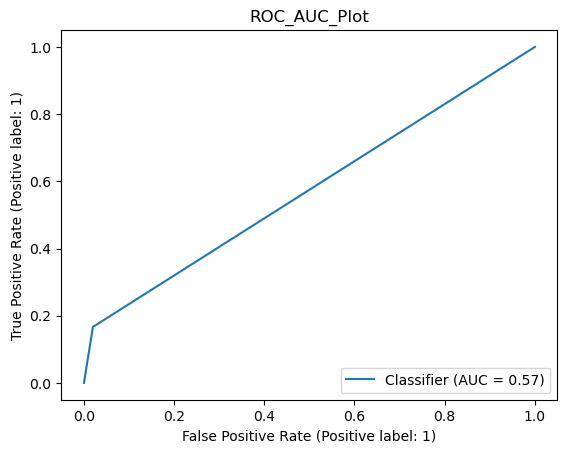

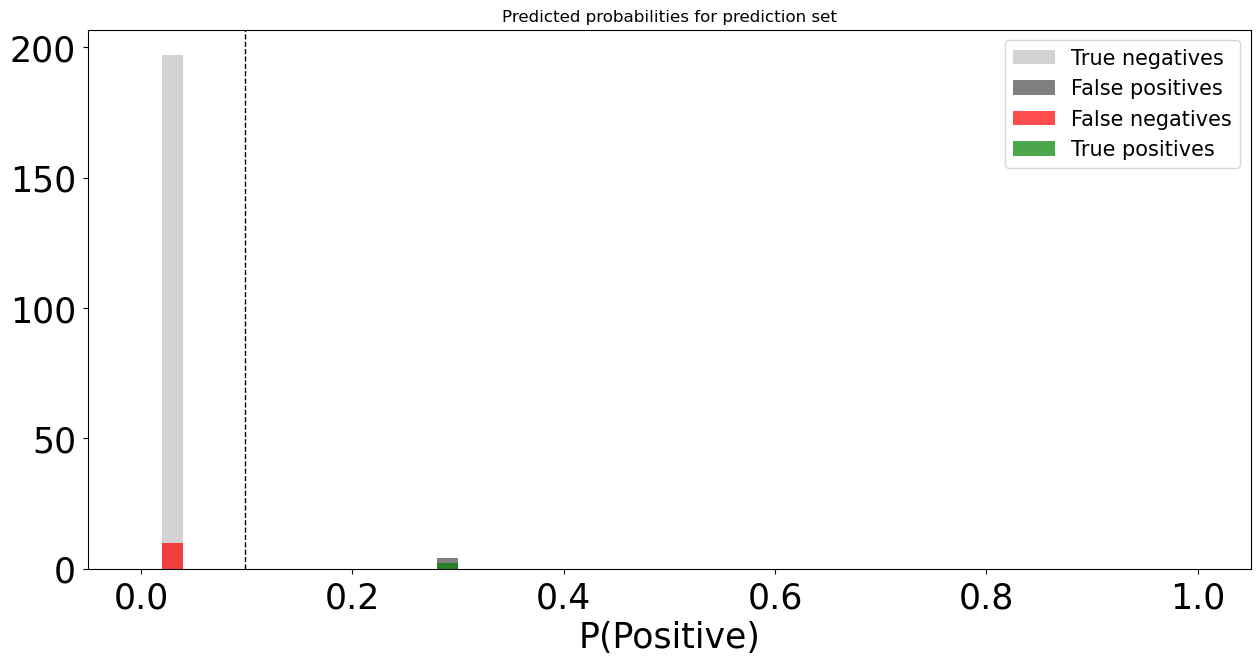

Test P(1) =  5.63%
Test P(1 | predicted 1) =  33.33%
Test P(1 | predicted 0) =  4.83%

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       201
           1       0.33      0.17      0.22        12

    accuracy                           0.93       213
   macro avg       0.64      0.57      0.59       213
weighted avg       0.92      0.93      0.92       213



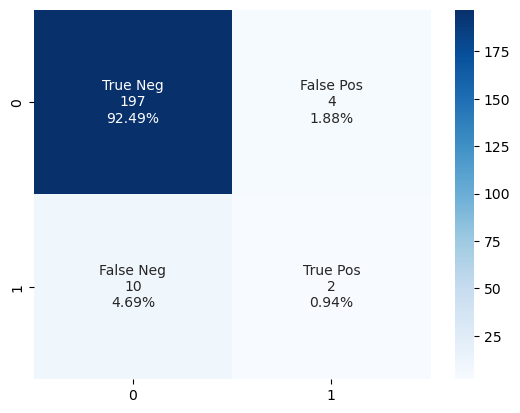

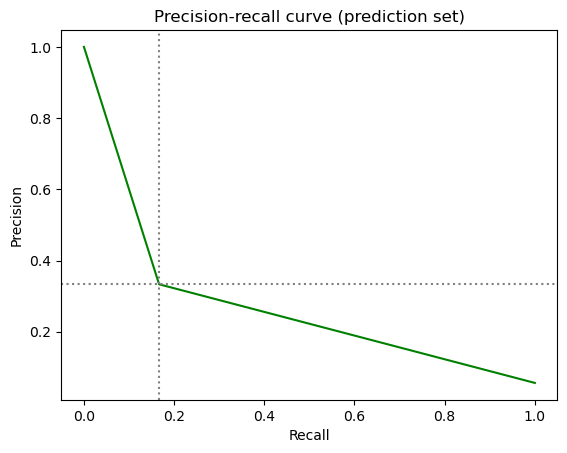

Cross validation results: 

fit_time: 0.00898583730061849 (SD: 0.0008990130927209612)
score_time: 0.0024750391642252606 (SD: 0.0006248947317639923)
test_accuracy: 0.942311507936508 (SD: 0.023695715656109544)
test_precision: 0.1611111111111111 (SD: 0.20742394113993853)
test_f1: 0.1546031746031746 (SD: 0.19394357258605577)
test_roc_auc: 0.5882513661202184 (SD: 0.13414326698318024)
test_neg_log_loss: -0.23279006623409249 (SD: 0.2552592207145929)
test_neg_brier_score: -0.039591622964342106 (SD: 0.006827234485865936)

Predictions made: 213
CPU times: user 659 ms, sys: 94.8 ms, total: 754 ms
Wall time: 5.97 s


In [19]:
%%time

model_description = "Decision tree"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.tree import DecisionTreeClassifier

# first use cross validation to find the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_dt, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_dt = DecisionTreeClassifier(random_state=random_state, **params)
predictions = surveyml.run_prediction_model(classifier_dt)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with random forest

Here, we use random forest to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Random forest
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 100 candidates, totalling 1500 fits

Best neg_brier_score: -0.03583590714973852
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': None, 'bootstrap': True}

Running prediction model...

      Training set: (318, 144) (13 positive)
    Prediction set: (213, 144)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.4712926685704278

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.

          Train accuracy:  99.69%
         Train precision:  92.86%
               Train F-1:  0.96
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  91.08%
    Prediction precision:  11.11%
          Prediction F-1:  0.095
      Test ROC_AUC Score:  0.52


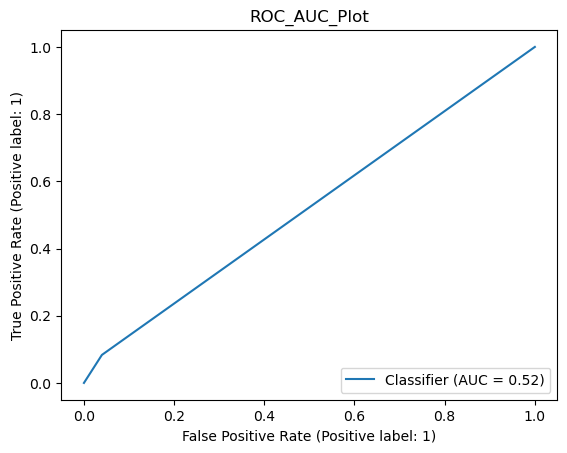

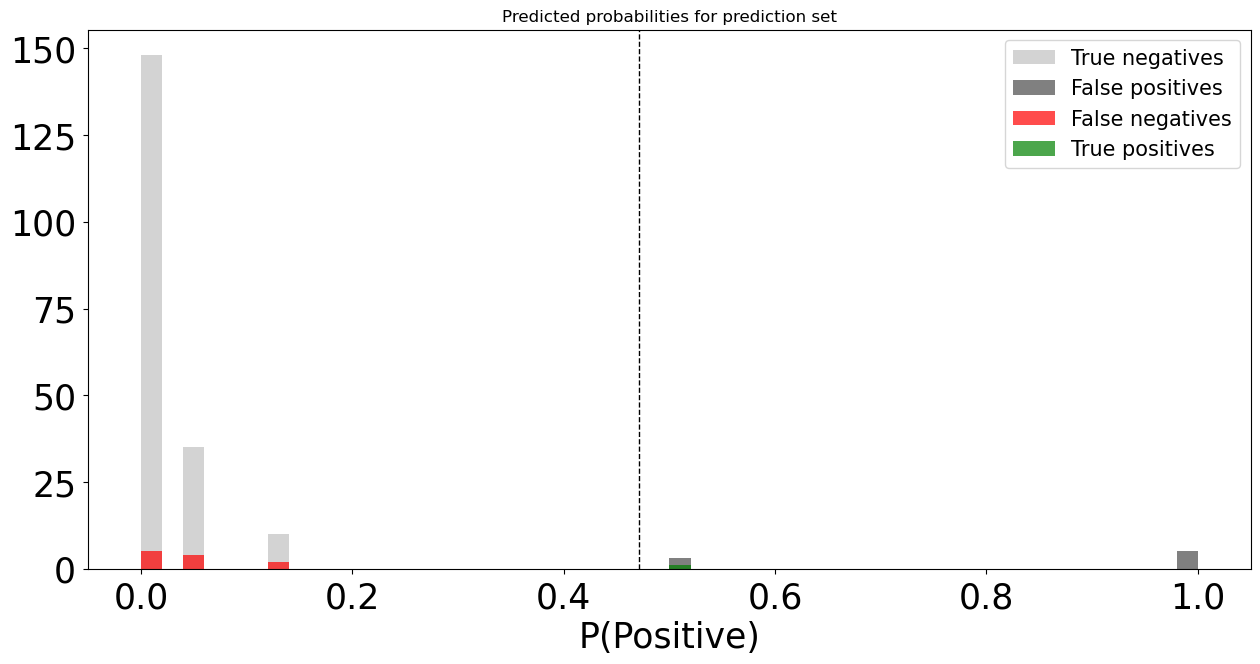

Test P(1) =  5.63%
Test P(1 | predicted 1) =  11.11%
Test P(1 | predicted 0) =  5.39%

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       201
           1       0.11      0.08      0.10        12

    accuracy                           0.91       213
   macro avg       0.53      0.52      0.52       213
weighted avg       0.90      0.91      0.90       213



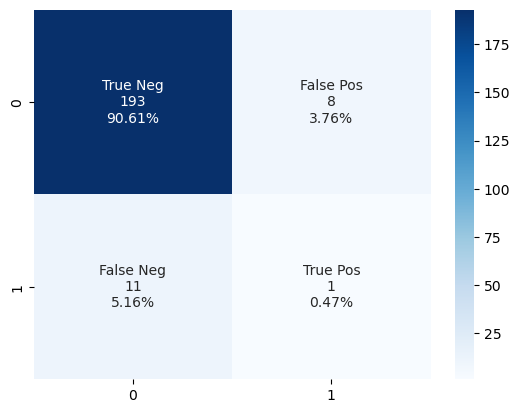

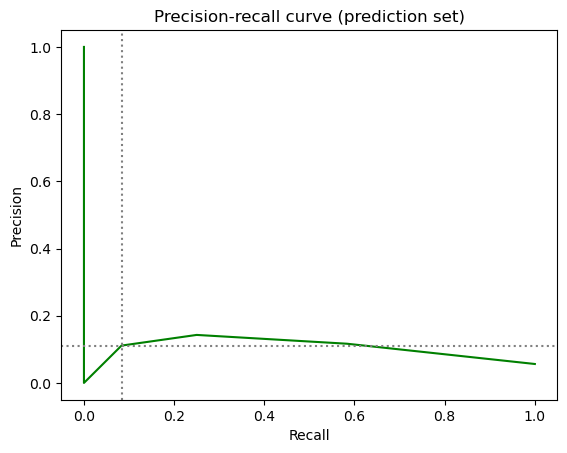

Cross validation results: 

fit_time: 3.0537790934244793 (SD: 0.22840409679680831)
score_time: 0.04393121401468913 (SD: 0.0016687130148103136)
test_accuracy: 0.963343253968254 (SD: 0.0148044772133782)
test_precision: 0.3 (SD: 0.4396968652757639)
test_f1: 0.22 (SD: 0.33306655991458123)
test_roc_auc: 0.8180327868852457 (SD: 0.08994868605048816)
test_neg_log_loss: -0.17187139120436387 (SD: 0.1311119655322501)
test_neg_brier_score: -0.033997080480900985 (SD: 0.009313330883423197)

Predictions made: 213
CPU times: user 5.26 s, sys: 235 ms, total: 5.49 s
Wall time: 40.6 s


In [20]:
%%time

model_description = "Random forest"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from sklearn.ensemble import RandomForestClassifier

# first use cross validation to find the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=50)
search_params = {'max_features': [None, 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5, 7, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'class_weight': [None], 'bootstrap': [True]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_rf, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_rf = RandomForestClassifier(random_state=random_state, n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_rf)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with XGBoost

Here, we use the XGBoost algorithm to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: XGBoost
     Scoring: neg_brier_score

Running random CV search for best hyperparameters...

   Scoring: neg_brier_score
Iterations: 100

Fitting 15 folds for each of 54 candidates, totalling 810 fits


/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Best neg_brier_score: -0.03540310575868972
Parameters: {'subsample': 1, 'scale_pos_weight': 1, 'min_child_weight': 1, 'max_depth': 4}

Running prediction model...

      Training set: (318, 144) (13 positive)
    Prediction set: (213, 144)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...

   Final threshold: 0.1899214094504714

Fitting model...

Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.

          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  93.90%
    Prediction precision:  33.33%
          Prediction F-1:  0.13
      Test ROC_AUC Score:  0.54


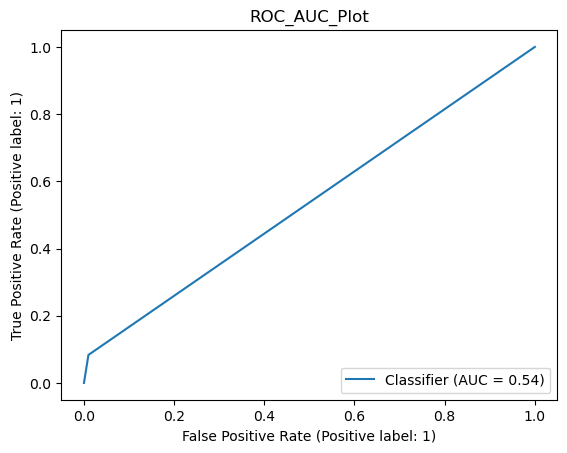

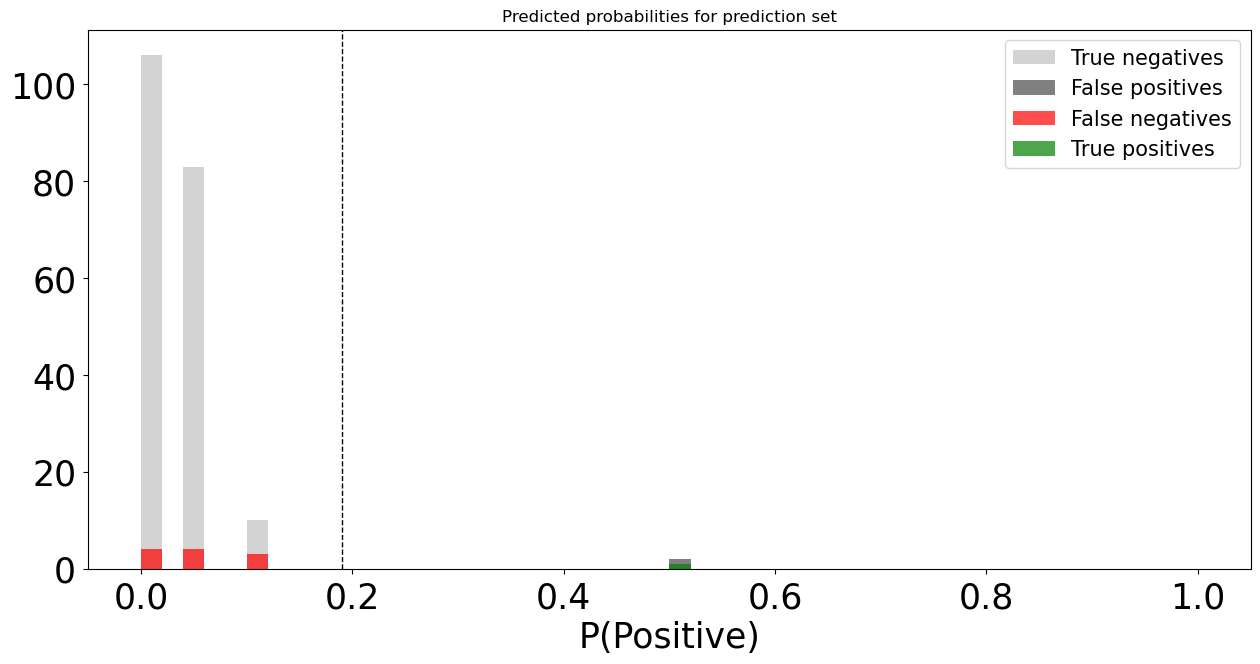

Test P(1) =  5.63%
Test P(1 | predicted 1) =  33.33%
Test P(1 | predicted 0) =  5.24%

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       201
           1       0.33      0.08      0.13        12

    accuracy                           0.94       213
   macro avg       0.64      0.54      0.55       213
weighted avg       0.91      0.94      0.92       213



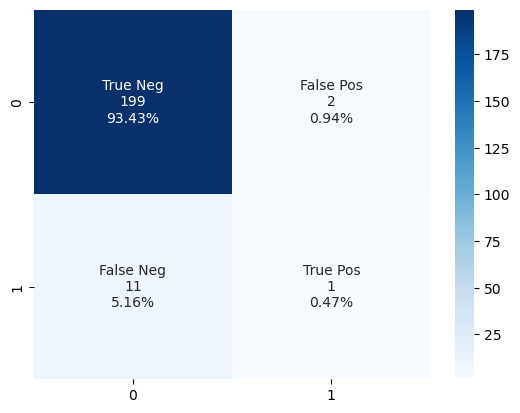

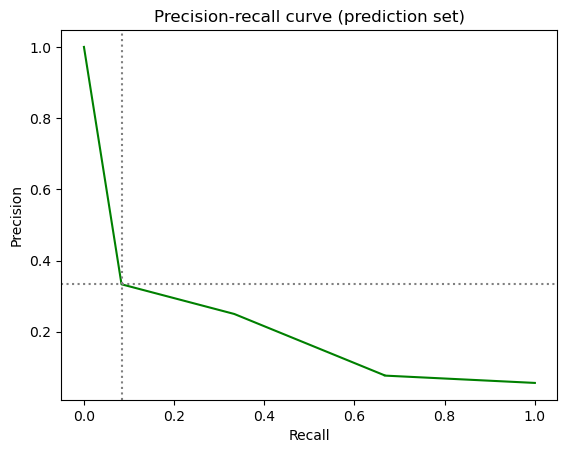

Cross validation results: 

fit_time: 0.7420372486114502 (SD: 0.12437263643339429)
score_time: 0.004432455698649088 (SD: 0.0029510758575483635)
test_accuracy: 0.9497685185185186 (SD: 0.02557617585830515)
test_precision: 0.34111111111111114 (SD: 0.4191201837123354)
test_f1: 0.22481481481481483 (SD: 0.2337110405610093)
test_roc_auc: 0.7282331511839708 (SD: 0.13887243475050426)
test_neg_log_loss: -0.2575552679241195 (SD: 0.2854954380575778)
test_neg_brier_score: -0.03847287949201853 (SD: 0.008227346611867555)

Predictions made: 213
CPU times: user 2.88 s, sys: 1.24 s, total: 4.12 s
Wall time: 12.3 s


In [21]:
%%time

model_description = "XGBoost"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

from xgboost import XGBClassifier

# first use cross validation to find the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=50)
search_params = {'max_depth': [2, 3, 4, 5, 7, 10], 'min_child_weight': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'scale_pos_weight': [1]}
params = surveyml.cv_for_best_hyperparameters(classifier=classifier_xb, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# then fit the model using the optimal hyperparameters
classifier_xb = XGBClassifier(random_state=random_state, objective='binary:logistic', eval_metric='aucpr', n_estimators=500, **params)
predictions = surveyml.run_prediction_model(classifier_xb)
print()
print(f"Predictions made: {len(predictions)}")
# surveyml.report_feature_importance(surveyml.fitted_estimator.feature_importances_)

### Binary classification prediction with a neural network

Here, we use a neural network to predict the classification defined during the preprocessing stage above.

  Predicting: REJECTED
       Model: Neural network
     Scoring: neg_brier_score

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 144)               20880     
                                                                 
 dense_49 (Dense)            (None, 72)                10440     
                                                                 
 dense_50 (Dense)            (None, 1)                 73        
                                                                 
Total params: 31,393
Trainable params: 31,393
Non-trainable params: 0
_________________________________________________________________
None

Running prediction model...

      Training set: (318, 144) (13 positive)
    Prediction set: (213, 144)
Calibration method: isotonic
Decision threshold: optimal_f (1)

Cross-validating to find optimal threshold...



2023-01-05 16:45:37.712265: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:37.713240: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:37.713712: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:37.724775: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:37.876873: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:43.010429: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:43.061954: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 16:45:47.981174: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   Final threshold: 0.48517759442329406

Fitting model...



Cross-validating model on training set...



/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/crobert/miniforge3/envs/ml4qc/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


          Train accuracy:  100.00%
         Train precision:  100.00%
               Train F-1:  1.0
     Train ROC_AUC Score:  1.0
     Prediction accuracy:  92.96%
    Prediction precision:  0.00%
          Prediction F-1:  0.0
      Test ROC_AUC Score:  0.49


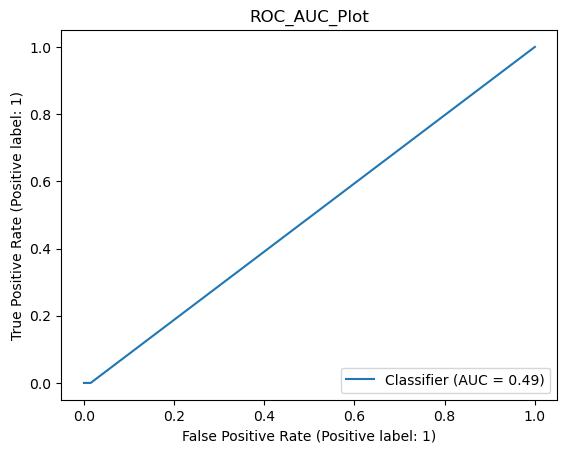

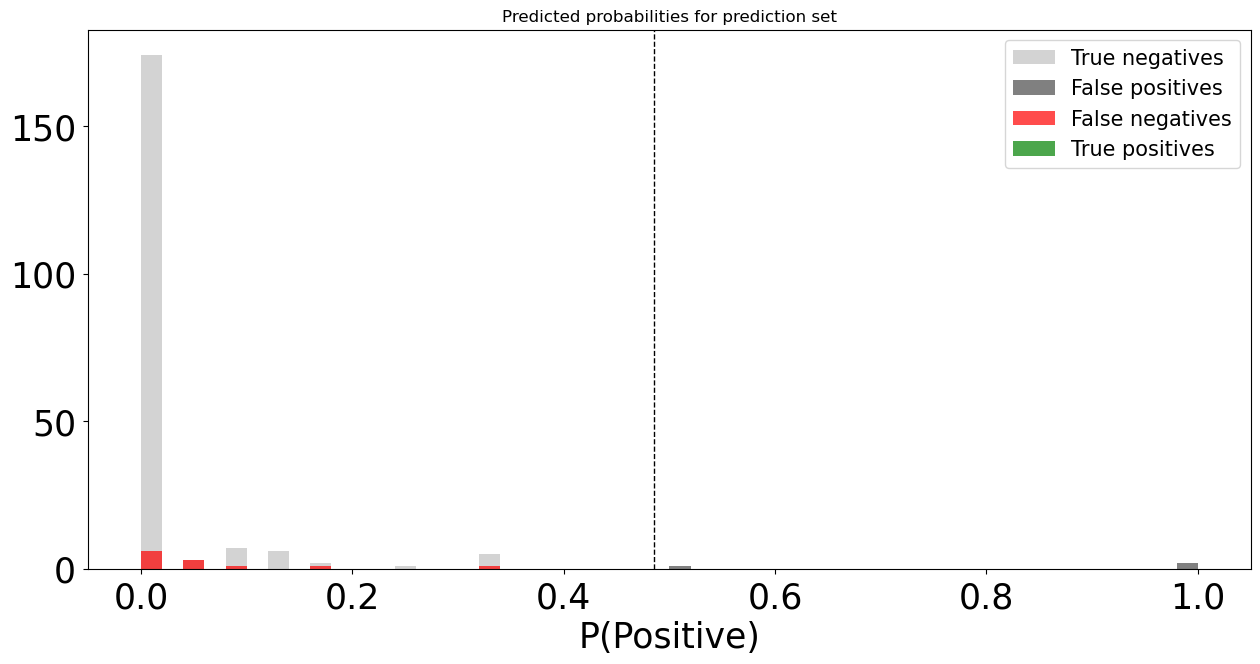

Test P(1) =  5.63%
Test P(1 | predicted 1) =  0.00%
Test P(1 | predicted 0) =  5.71%

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       201
           1       0.00      0.00      0.00        12

    accuracy                           0.93       213
   macro avg       0.47      0.49      0.48       213
weighted avg       0.89      0.93      0.91       213



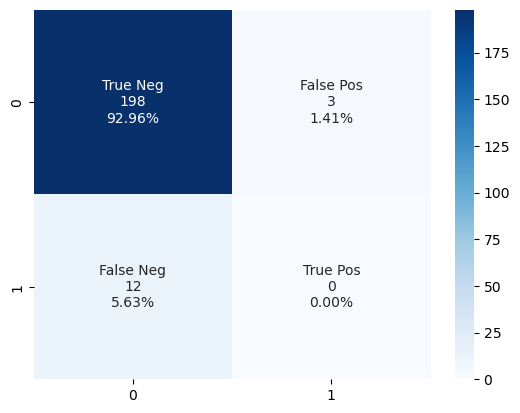

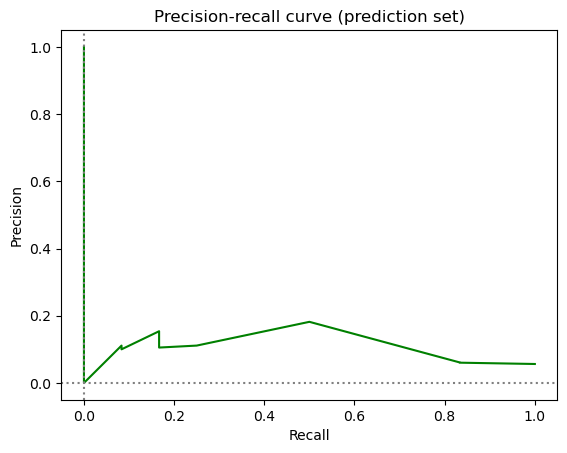

Cross validation results: 

fit_time: 7.592994181315104 (SD: 0.6334169295123451)
score_time: 0.09257324536641438 (SD: 0.020748855483414787)
test_accuracy: 0.9612929894179895 (SD: 0.017826451309504568)
test_precision: 0.4888888888888889 (SD: 0.41035967361376413)
test_f1: 0.35851851851851857 (SD: 0.27305516308073724)
test_roc_auc: 0.8302367941712204 (SD: 0.13009449981948407)
test_neg_log_loss: -0.35692126744273167 (SD: 0.35141234326664417)
test_neg_brier_score: -0.03126720851133643 (SD: 0.012870811392783064)

Predictions made: 213
CPU times: user 8.09 s, sys: 929 ms, total: 9.02 s
Wall time: 46 s


In [23]:
%%time

model_description = "Neural network"
model_scoring = 'neg_brier_score'
print(f"  Predicting: {target_description}")
print(f"       Model: {model_description}")
print(f"     Scoring: {model_scoring}")
print()

import numpy as np
from scikeras.wrappers import KerasClassifier

# # Option 1: use cross validation to find the optimal hyperparameters
# import sklearn as skl
# classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0)
# #   test initial bias to match imbalance in classes (from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)
# search_params = {'epochs': [10, 20, 40, 80, 100], 'batch_size': [16, 32], 'class_weight': [None], 'model__features': [surveyml.num_features], 'model__hidden_layers': [1, 2], 'model__initial_units': [surveyml.num_features, surveyml.num_features / 2], 'model__activation': ['relu', 'sigmoid'], 'model__l2_regularization': [True, False], 'model__l2_factor': skl.utils.fixes.loguniform(0.00001, 0.1), 'model__include_dropout': [True, False], 'model__dropout_rate': np.linspace(start=0.05, stop=0.5, num=10), 'model__output_bias': [None, np.log([surveyml.pos_train/surveyml.neg_train])]}
# params = surveyml.cv_for_best_hyperparameters(classifier=classifier_nn, search_params=search_params, model_scoring=model_scoring, n_iter=100)

# Option 2: use results from an earlier CV search
# Best neg_brier_score: -0.02854177733812206
# Parameters: {'batch_size': 32, 'class_weight': None, 'epochs': 100, 'model__activation': 'sigmoid', 'model__dropout_rate': 0.45, 'model__features': 144, 'model__hidden_layers': 2, 'model__include_dropout': False, 'model__initial_units': 144, 'model__l2_factor': 0.003263877601339443, 'model__l2_regularization': True, 'model__output_bias': array([-3.15536242])}
# Best neg_brier_score: -0.03172571075887665
params = {'batch_size': 32, 'class_weight': None, 'epochs': 100, 'model__activation': 'sigmoid', 'model__dropout_rate': 0.45, 'model__features': surveyml.num_features, 'model__hidden_layers': 2, 'model__include_dropout': False, 'model__initial_units': surveyml.num_features, 'model__l2_factor': 0.003263877601339443, 'model__l2_regularization': True, 'model__output_bias': [-3.15536242]}

# output summary of model
print(surveyml.build_nn_model(**{param[len("model__"):]:params[param] for param in params if param.startswith("model__")}).summary())
print()

# then fit the model using the optimal hyperparameters
classifier_nn = KerasClassifier(random_state=random_state, model=surveyml.build_nn_model, verbose=0, **params)
predictions = surveyml.run_prediction_model(classifier_nn, supports_cv=True)
print()
print(f"Predictions made: {len(predictions)}")